In [27]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from optbinning import BinningProcess, Scorecard
from optbinning.scorecard import plot_auc_roc, plot_ks
import matplotlib.pyplot as plt

accepts = pd.read_csv("accepted_customers.csv")
rejects = pd.read_csv("rejected_customers.csv")

In [28]:
#checking that the classes are in fact balanced after oversampling
accepts['GB'].mean()

np.float64(0.5)

In [29]:
# checking that weights were correctly assigned 
weighted_bad_rate = (
    accepts['GB'] * accepts['_freq_']
).sum() / accepts['_freq_'].sum()

weighted_bad_rate

np.float64(0.03225806451612903)

In [30]:
# Ensure GB is numeric 0/1
accepts["GB"] = pd.to_numeric(accepts["GB"], errors="coerce").astype(int)

# ensuring existing weight column is a float and renaming as weight for consistency 
accepts["_freq_"] = pd.to_numeric(accepts["_freq_"], errors="coerce").astype(float)

# Quick check
accepts[["GB", "_freq_"]].head()

,GB,_freq_
0,0,30.0
1,0,30.0
2,0,30.0
3,0,30.0
4,0,30.0


In [31]:
#splitting the data for accepts 
accept_train, accept_test = train_test_split(accepts, test_size=0.3, random_state=42)

print("Train shape:", accept_train.shape)
print("Test shape :", accept_test.shape)

Train shape: (2100, 24)
Test shape : (900, 24)


In [32]:
#BinningProcess + variable selection by IV
colnames = list(accept_train.columns)

accept_y_train = accept_train["GB"]
w_train = accept_train["_freq_"]

# Define predictors
colnames = list(accept_train.columns)
for drop_col in ["GB", "_freq_"]:
    if drop_col in colnames:
        colnames.remove(drop_col)

accept_X_train = accept_train[colnames]


selection_criteria = {"iv": {"min": 0.1, "max": 1}}

categorical_vars = ["BUREAU", "CAR", "CARDS", "DIV", "EC_CARD", "FINLOAN", "LOCATION", "NAT", "PRODUCT", "PROF", "REGN", "TEL", "RESID"]
categorical_vars = [c for c in categorical_vars if c in accept_X_train.columns]

bin_proc = BinningProcess(
    variable_names=colnames,
    selection_criteria=selection_criteria,
    categorical_variables=categorical_vars,
    #max_n_bins=6,
    #min_bin_size=0.05
)

summary = bin_proc.fit(accept_X_train, accept_y_train, sample_weight=w_train).summary()
summary.sort_values("iv", ascending=False).head(15)

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
2,AGE,numerical,OPTIMAL,True,9,0.422285,0.050597,0.35045,0.033864
8,INCOME,numerical,OPTIMAL,True,7,0.224382,0.02763,0.263151,0.028643
4,TMJOB1,numerical,OPTIMAL,True,8,0.19994,0.02426,0.228657,0.115531
21,CARDS,categorical,OPTIMAL,True,2,0.187317,0.023067,0.193716,0.439001
9,EC_CARD,categorical,OPTIMAL,True,2,0.151663,0.018686,0.168293,0.350353
1,PERS_H,numerical,OPTIMAL,True,4,0.141767,0.017583,0.186383,0.025475
20,CAR,categorical,OPTIMAL,False,2,0.055136,0.006849,0.098059,0.090778
3,TMADD,numerical,OPTIMAL,False,6,0.05318,0.006586,0.114924,0.009481
0,CHILDREN,numerical,OPTIMAL,False,4,0.044305,0.005527,0.10766,0.01092
5,TEL,categorical,OPTIMAL,False,2,0.044224,0.00549,0.08091,0.060903


In [33]:
# Fit the scorecard (logistic regression + PDO scaling) - with only accepts data 
estimator = LogisticRegression(
    solver="lbfgs",
    max_iter=2000
)

scorecard = Scorecard(
    binning_process=bin_proc,
    estimator=estimator,
    scaling_method="pdo_odds",
    scaling_method_params={
        "pdo": 50,               # 50 points for doubling the odds
        "scorecard_points": 500, # score at reference odds
        "odds": 20               # reference odds = 20:1
    }
     
)

scorecard.fit(accept_X_train, accept_y_train, sample_weight=accept_train["_freq_"])

,binning_process,BinningProces... 'CARDS'])
,estimator,LogisticRegre...max_iter=2000)
,scaling_method,'pdo_odds'
,scaling_method_params,"{'odds': 20, 'pdo': 50, 'scorecard_points': 500}"
,intercept_based,False
,reverse_scorecard,False
,rounding,False
,verbose,False
,variable_names,"['CHILDREN', 'PERS_H', ...]"
,max_n_prebins,20
,min_prebin_size,0.05


In [34]:
# scorecard summary - accepts data 
scorecard.table(style="summary")

,Variable,Bin,Points
0,PERS_H,"(-inf, 1.50)",75.867569
1,PERS_H,"[1.50, 2.50)",95.591269
2,PERS_H,"[2.50, 3.50)",95.201039
3,PERS_H,"[3.50, inf)",93.809062
4,PERS_H,Special,87.903059
5,PERS_H,Missing,87.903059
0,AGE,"(-inf, 22.50)",22.150736
1,AGE,"[22.50, 27.50)",59.942796
2,AGE,"[27.50, 30.50)",74.426714
3,AGE,"[30.50, 33.50)",95.780155


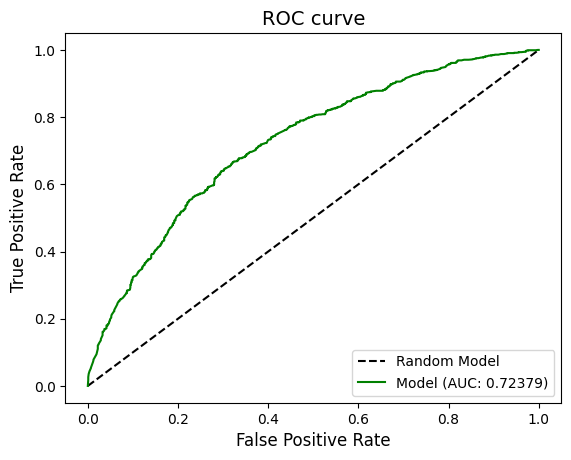

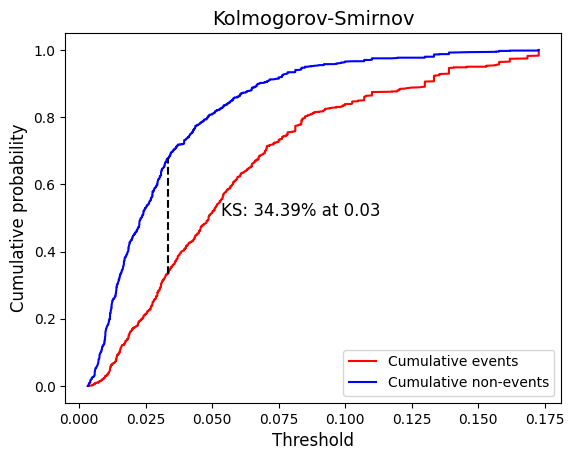

In [35]:
# looking at the accuracy 
y_pred_train = scorecard.predict_proba(accept_X_train)[:, 1]

plot_auc_roc(accept_y_train, y_pred_train)
plt.show()

plot_ks(accept_y_train, y_pred_train)
plt.show()

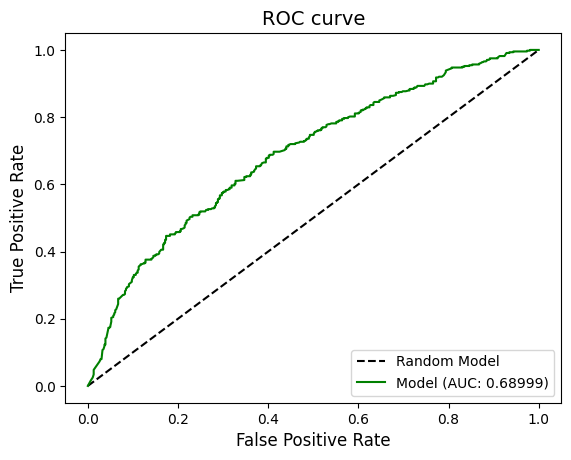

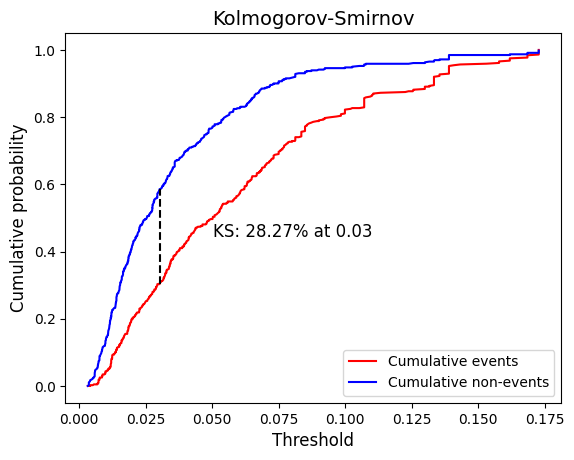

In [36]:
# accuracy on the accepts test data 
accept_X_test = accept_test[colnames]
accept_y_test = accept_test["GB"]

accept_y_pred_test = scorecard.predict_proba(accept_X_test)[:, 1]

plot_auc_roc(accept_y_test, accept_y_pred_test)
plt.show()

plot_ks(accept_y_test, accept_y_pred_test)
plt.show()

In [37]:
# looking at the weighted counts of each class 
X_acc = accepts[colnames]
y_acc = accepts["GB"]
w_acc = accepts["_freq_"]

# Check effective counts after weighting
accepts.groupby("GB")["_freq_"].sum()

GB
0    45000.0
1     1500.0
Name: _freq_, dtype: float64

### Reject Inferencing

In [38]:
# reject inferencing 
rejects_path = "rejected_customers.csv"

if os.path.exists(rejects_path):
    rejects = pd.read_csv(rejects_path)
    rejects["_freq_"] = 1  # all equal weight

    # Ensure the rejects file has the predictor columns needed
    missing = [c for c in colnames if c not in rejects.columns]
    if missing:
        raise ValueError(f"rejects.csv is missing required columns: {missing}")

    X_r = rejects[colnames].copy()
    rejects["y_pred"] = scorecard.predict_proba(X_r)[:, 1]

    cutoff = 0.03
    rejects["GB"] = (rejects["y_pred"] > cutoff).astype(int)

    #rejects["_freq_"] = rejects["GB"].apply(lambda x: 1 if x == 0 else 1.0)
    #rejects = rejects.drop(columns=["y_pred"])

    # FINAL modeling weights (from spreadsheet)
    accepts["_freq_"] = accepts["GB"].map({
    0: 29.9628483,   # Good
    1: 1.0           # Bad (anchor)
        })

    rejects["_freq_"] = 10.31991744

    comb_hard = pd.concat([accepts, rejects], ignore_index=True)

    print("rejects loaded and combined. comb_hard shape:", comb_hard.shape)
    comb_hard.head()
else:
    print("No rejects.csv found — skipping reject inference section.")

rejects loaded and combined. comb_hard shape: (4500, 25)


In [39]:
#rerunning scorecard with reject inferencing complete 

X_comb = comb_hard[colnames]
y_comb = comb_hard["GB"]
w_comb = comb_hard["_freq_"]

X_train, X_test, y_train, y_test, w_train, w_val = train_test_split(
    X_comb, y_comb, w_comb,
    test_size=0.3,      # 30% validation
    random_state=42,    # reproducible
    stratify=y_comb     # keep class balance
)

scorecard_comb = Scorecard(
    binning_process=bin_proc,
    estimator=LogisticRegression(solver="lbfgs", max_iter=2000),
    scaling_method="pdo_odds",
    scaling_method_params={
        "pdo": 50,
        "scorecard_points": 500,
        "odds": 20
    })

scorecard_comb.fit(X_train, y_train, sample_weight=w_train)

summary = scorecard_comb.binning_process_.summary()
summary.sort_values("iv", ascending=False).head(15)


,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
16,PRODUCT,categorical,OPTIMAL,False,5,2.670899,0.288104,0.757273,0.0
2,AGE,numerical,OPTIMAL,False,10,1.300628,0.138334,0.563482,0.021498
4,TMJOB1,numerical,OPTIMAL,False,9,1.090824,0.112938,0.48586,0.040565
8,INCOME,numerical,OPTIMAL,True,9,0.800755,0.094302,0.472586,0.390766
19,PROF,categorical,OPTIMAL,True,4,0.698213,0.076564,0.327036,0.138097
21,CARDS,categorical,OPTIMAL,True,2,0.539551,0.063029,0.291395,0.516897
9,EC_CARD,categorical,OPTIMAL,True,2,0.460421,0.053931,0.261715,0.53974
18,NAT,categorical,OPTIMAL,True,3,0.338848,0.039153,0.214361,0.398386
1,PERS_H,numerical,OPTIMAL,True,4,0.299076,0.036814,0.266161,0.141996
3,TMADD,numerical,OPTIMAL,True,9,0.208355,0.025651,0.252964,0.461279


In [40]:
tbl = scorecard_comb.table(style="summary")
tbl

,Variable,Bin,Points
0,CHILDREN,"(-inf, 0.50)",53.368354
1,CHILDREN,"[0.50, 1.50)",30.720387
2,CHILDREN,"[1.50, 2.50)",31.052287
3,CHILDREN,"[2.50, inf)",32.088409
4,CHILDREN,Special,43.313032
5,CHILDREN,Missing,43.313032
0,PERS_H,"(-inf, 1.50)",-9.911784
1,PERS_H,"[1.50, 3.50)",75.956007
2,PERS_H,"[3.50, 4.50)",76.887605
3,PERS_H,"[4.50, inf)",83.011204


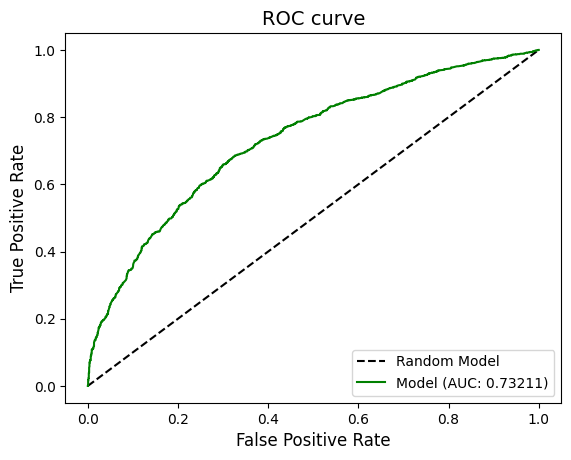

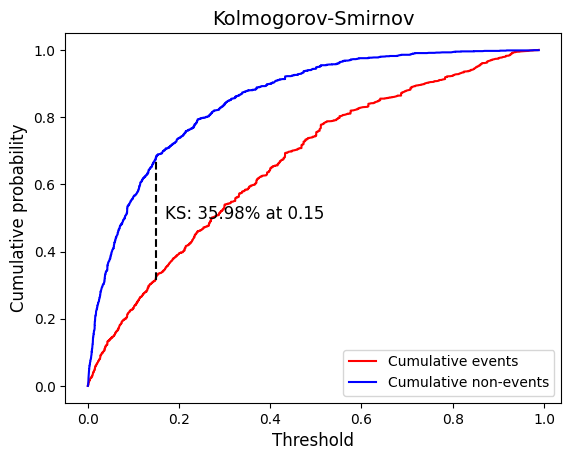

In [41]:
# evaluating on training data 
y_pred_train = scorecard_comb.predict_proba(X_train)[:, 1]

plot_auc_roc(y_train, y_pred_train)
plt.show()

plot_ks(y_train, y_pred_train)
plt.show()

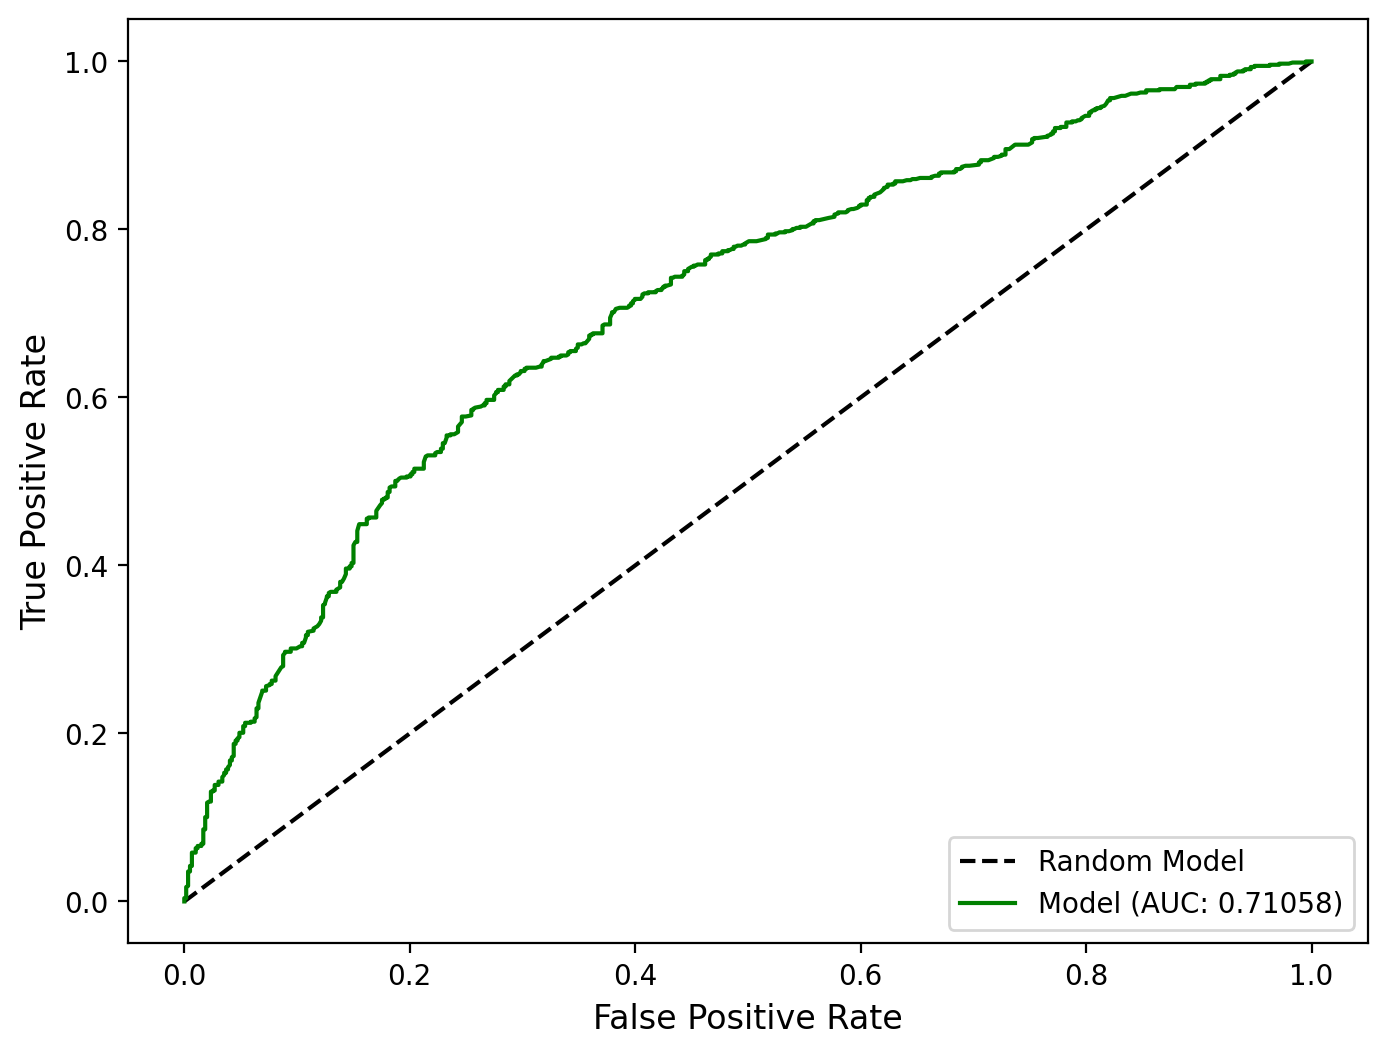

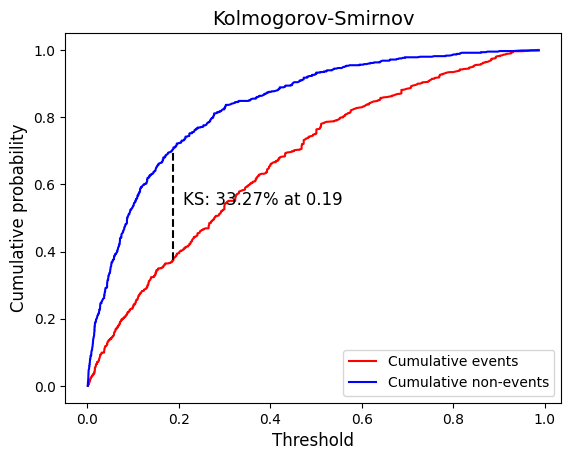

In [52]:
# evaluating on test data 

y_pred_test = scorecard_comb.predict_proba(X_test)[:, 1]

plt.figure(figsize = (8,6), dpi=200)
plot_auc_roc(y_test, y_pred_test)

plt.title("")  
plt.show()

plot_ks(y_test, y_pred_test)
plt.show()

In [43]:
# scoring the test set 

test_final = X_test.copy()
test_final["GB"] = y_test.values

test_final["_freq_"] = w_val.values

if "_freq_" not in test_final.columns:
    test_final["_freq_"] = 1.0

test_final["score"] = scorecard_comb.score(test_final[colnames])

test_final[["score", "GB"]].head()


,score,GB
151,391.818548,0
112,599.962822,0
3959,418.813958,1
3390,292.957562,1
2711,449.425424,1


In [44]:
# Create deciles and compute PD per decile

good_weight = 29.9628483

test_final["decile"] = pd.qcut(test_final["score"], 10, labels=False)

# Counts by decile
bad_ct = test_final.loc[test_final["GB"] == 1].groupby("decile").size()
good_ct = test_final.loc[test_final["GB"] == 0].groupby("decile").size()

# Align indices to ensure 0..9 exist
all_dec = pd.Index(range(10), name="decile")
bad_ct = bad_ct.reindex(all_dec, fill_value=0)
good_ct = good_ct.reindex(all_dec, fill_value=0)

PD = bad_ct / (good_ct * good_weight + bad_ct)
PD

decile
0    0.153387
1    0.104162
2    0.078162
3    0.060656
4    0.047675
5    0.033694
6    0.024420
7    0.019408
8    0.026849
9    0.010240
dtype: float64

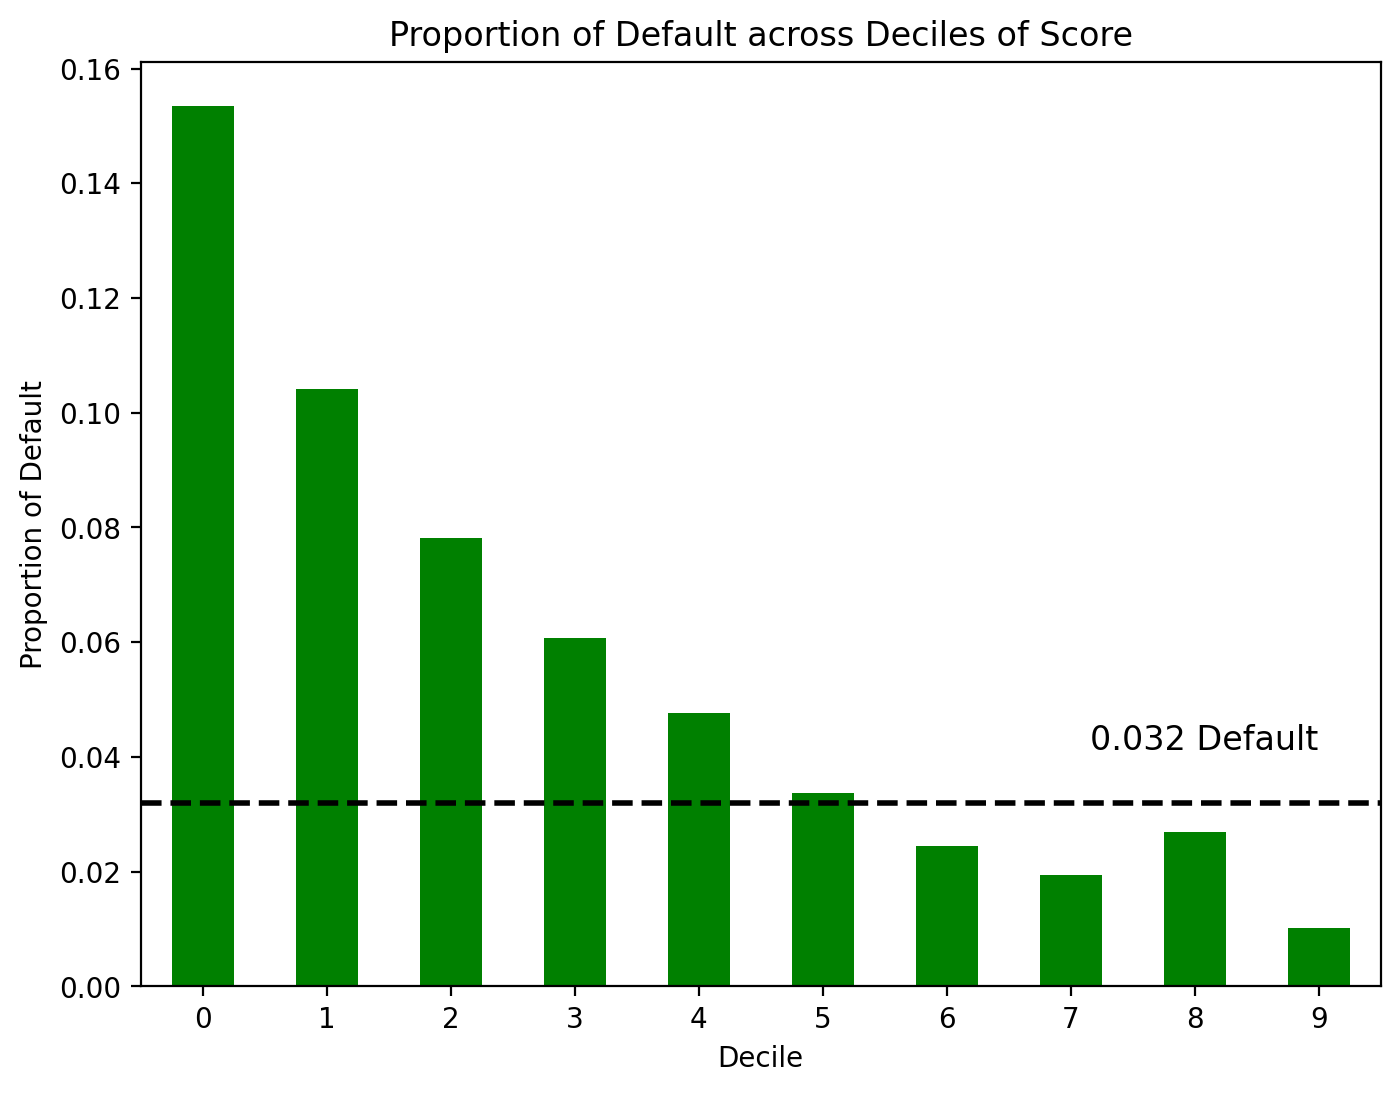

In [45]:
plt.figure(figsize=(8, 6), dpi=200)
PD.plot(kind="bar", color = "green")
plt.axhline(y=0.032, color="black", linestyle="--", linewidth=2)
plt.text(x=9, y=0.04, s="0.032 Default", color="black", ha="right", va="bottom", fontsize=12)

plt.title("Proportion of Default across Deciles of Score")
plt.xlabel("Decile")
plt.ylabel("Proportion of Default")
plt.xticks(rotation=0)
plt.show()

In [46]:
def plot_default_and_acceptance_by_score(
    df: pd.DataFrame,
    score_col: str = "score",
    bad_col: str = "GB",
    weight_col: str | None = None,
    n_bins: int = 250,
    smooth_window: int | None = 9,
    title: str = "Default Rate by Acceptance Across Score",
):
    keep_cols = [score_col, bad_col] + ([weight_col] if weight_col else [])
    d = df[keep_cols].copy()
    d = d.dropna(subset=[score_col, bad_col])

    d[score_col] = pd.to_numeric(d[score_col], errors="coerce")
    d[bad_col] = pd.to_numeric(d[bad_col], errors="coerce").astype(int)

    if weight_col and weight_col in d.columns:
        d[weight_col] = pd.to_numeric(d[weight_col], errors="coerce").fillna(0.0)
    else:
        d["_w"] = 1.0
        weight_col = "_w"

    d = d.dropna(subset=[score_col, bad_col])

    # Bin scores to stabilize the curve
    q = min(n_bins, max(5, d.shape[0]))
    d["_bin"] = pd.qcut(d[score_col], q=q, duplicates="drop")
    d["_score_mid"] = d["_bin"].apply(lambda x: (x.left + x.right) / 2.0).astype(float)

    # Aggregate per bin using in-frame weights (avoids index alignment bugs)
    grp = d.groupby("_score_mid", as_index=False).apply(
        lambda g: pd.Series({
            "wt": float(g[weight_col].sum()),
            "bad_wt": float((g[bad_col] * g[weight_col]).sum())
        })
    ).reset_index(drop=True)

    grp = grp.sort_values("_score_mid", ascending=False).reset_index(drop=True)

    total_wt = grp["wt"].sum()
    grp["cum_wt"] = grp["wt"].cumsum()
    grp["cum_bad_wt"] = grp["bad_wt"].cumsum()

    grp["accept_rate_pct"] = 100.0 * grp["cum_wt"] / total_wt
    grp["default_rate_pct"] = 100.0 * grp["cum_bad_wt"] / grp["cum_wt"]

    if smooth_window and smooth_window > 1:
        grp["accept_rate_pct"] = grp["accept_rate_pct"].rolling(
            window=smooth_window, min_periods=1
        ).mean()
        grp["default_rate_pct"] = grp["default_rate_pct"].rolling(
            window=smooth_window, min_periods=1
        ).mean()

    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.plot(grp["_score_mid"], grp["default_rate_pct"], label="Default Rate (%)")
    ax1.set_xlabel("Scorecard Value")
    ax1.set_ylabel("Default Rate (%)")
    ax1.set_title(title)

    ax2 = ax1.twinx()
    ax2.plot(grp["_score_mid"], grp["accept_rate_pct"], label="Acceptance Rate (%)")
    ax2.set_ylabel("Acceptance Rate (%)")
    ax2.set_ylim(0, 100)

    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc="center right")

    plt.tight_layout()
    plt.show()
    return grp

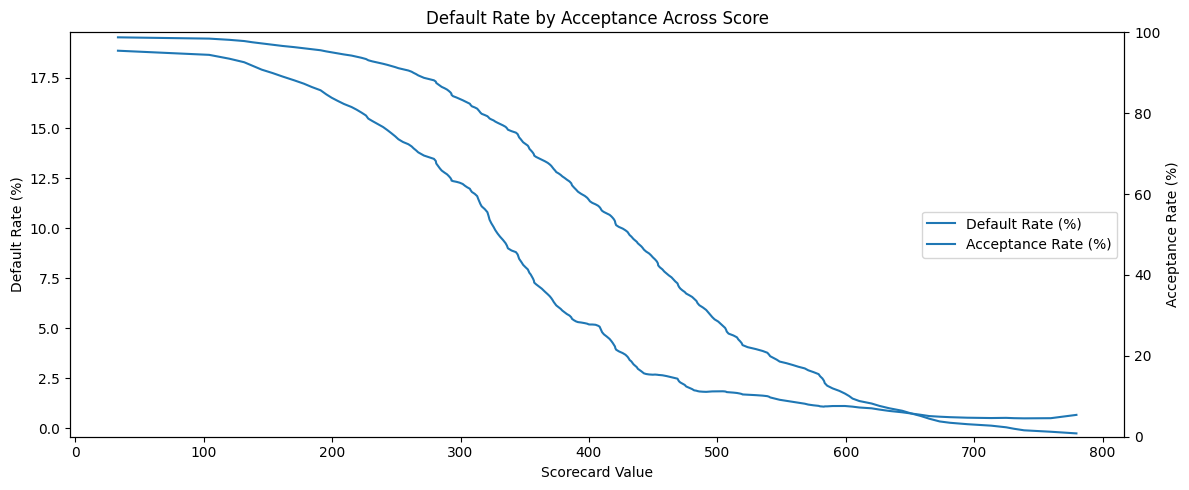

,_score_mid,wt,bad_wt,cum_wt,cum_bad_wt,accept_rate_pct,default_rate_pct
0,779.6765,150.814242,1.0,150.814242,1.0,0.822256,0.663067
1,759.7245,149.814242,0.0,300.628483,1.0,1.230657,0.497852
2,738.8810,120.851393,1.0,421.479876,2.0,1.586423,0.490074
3,731.0365,150.814242,1.0,572.294118,3.0,1.969869,0.498607
4,724.9395,120.851393,1.0,693.145511,4.0,2.331716,0.514302


In [47]:
curve_1 = plot_default_and_acceptance_by_score(
    test_final,
    score_col="score",
    bad_col="GB",
    weight_col="_freq_" if "_freq_" in test_final.columns else None,
    n_bins=250,
    smooth_window=9,
    title="Default Rate by Acceptance Across Score"
)

curve_1.head()

In [48]:
# Function for Profit and Acceptance Rate by Score
from matplotlib.ticker import FuncFormatter

def plot_profit_and_acceptance_by_score(
    df: pd.DataFrame,
    score_col: str = "score",
    bad_col: str = "GB",
    weight_col: str | None = None,
    profit_if_good: float = 2000.0,
    loss_if_bad: float = 52000.0,
    n_bins: int = 250,
    smooth_window: int | None = 9,
    title: str = "Profit by Acceptance Across Score",
):
    """
    Plot cumulative expected Profit ($) vs Acceptance Rate (%) across score cutoffs.

    For each cutoff score c:
      accepted = rows with score >= c
      acceptance rate = accepted / total
      profit($) = sum_over_accepted( weight * (profit_if_good*(1-bad) - loss_if_bad*bad) )
    """
    keep_cols = [score_col, bad_col] + ([weight_col] if weight_col else [])
    d = df[keep_cols].copy()
    d = d.dropna(subset=[score_col, bad_col])

    d[score_col] = pd.to_numeric(d[score_col], errors="coerce")
    d[bad_col] = pd.to_numeric(d[bad_col], errors="coerce").astype(int)

    if weight_col and weight_col in d.columns:
        d[weight_col] = pd.to_numeric(d[weight_col], errors="coerce").fillna(0.0)
    else:
        d["_w"] = 1.0
        weight_col = "_w"

    d = d.dropna(subset=[score_col, bad_col])

    # Per-row profit contribution
    d["_profit"] = d[weight_col] * (profit_if_good * (1 - d[bad_col]) - loss_if_bad * d[bad_col])

    # Bin scores to stabilize the curve
    q = min(n_bins, max(5, d.shape[0]))
    d["_bin"] = pd.qcut(d[score_col], q=q, duplicates="drop")
    d["_score_mid"] = d["_bin"].apply(lambda x: (x.left + x.right) / 2.0).astype(float)

    # Aggregate per bin (index-safe)
    grp = d.groupby("_score_mid", as_index=False).apply(
        lambda g: pd.Series({
            "wt": float(g[weight_col].sum()),
            "profit": float(g["_profit"].sum()),
        })
    ).reset_index(drop=True)
    

    grp = grp.sort_values("_score_mid", ascending=False).reset_index(drop=True)

    total_wt = grp["wt"].sum()
    grp["cum_wt"] = grp["wt"].cumsum()
    grp["cum_profit"] = grp["profit"].cumsum()

    grp["accept_rate_pct"] = 100.0 * grp["cum_wt"] / total_wt

    # Optional smoothing (rolling mean)
    if smooth_window and smooth_window > 1:
        grp["accept_rate_pct"] = grp["accept_rate_pct"].rolling(
            window=smooth_window, min_periods=1
        ).mean()
        grp["cum_profit"] = grp["cum_profit"].rolling(
            window=smooth_window, min_periods=1
        ).mean()

    # Plot with two y-axes
    fig, ax1 = plt.subplots(figsize=(8,6), dpi=200)

    ax1.plot(grp["_score_mid"], grp["cum_profit"], label="Profit ($)", color = "green")
    ax1.set_xlabel("Scorecard Value", size = 12)
    ax1.set_ylabel("Profit ($ millions)", size = 12)
    ax1.yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{x/1_000_000:.1f}"))
    ax1.set_title(title)

    ax2 = ax1.twinx()
    ax2.plot(grp["_score_mid"], grp["accept_rate_pct"], label="Acceptance Rate (%)", color = "blue")
    ax2.set_ylabel("Acceptance Rate (%)", size = 12)
    ax2.set_ylim(0, 100)

    # Combined legend on the right
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc="center right")

    plt.tight_layout()
    plt.show()

    return grp

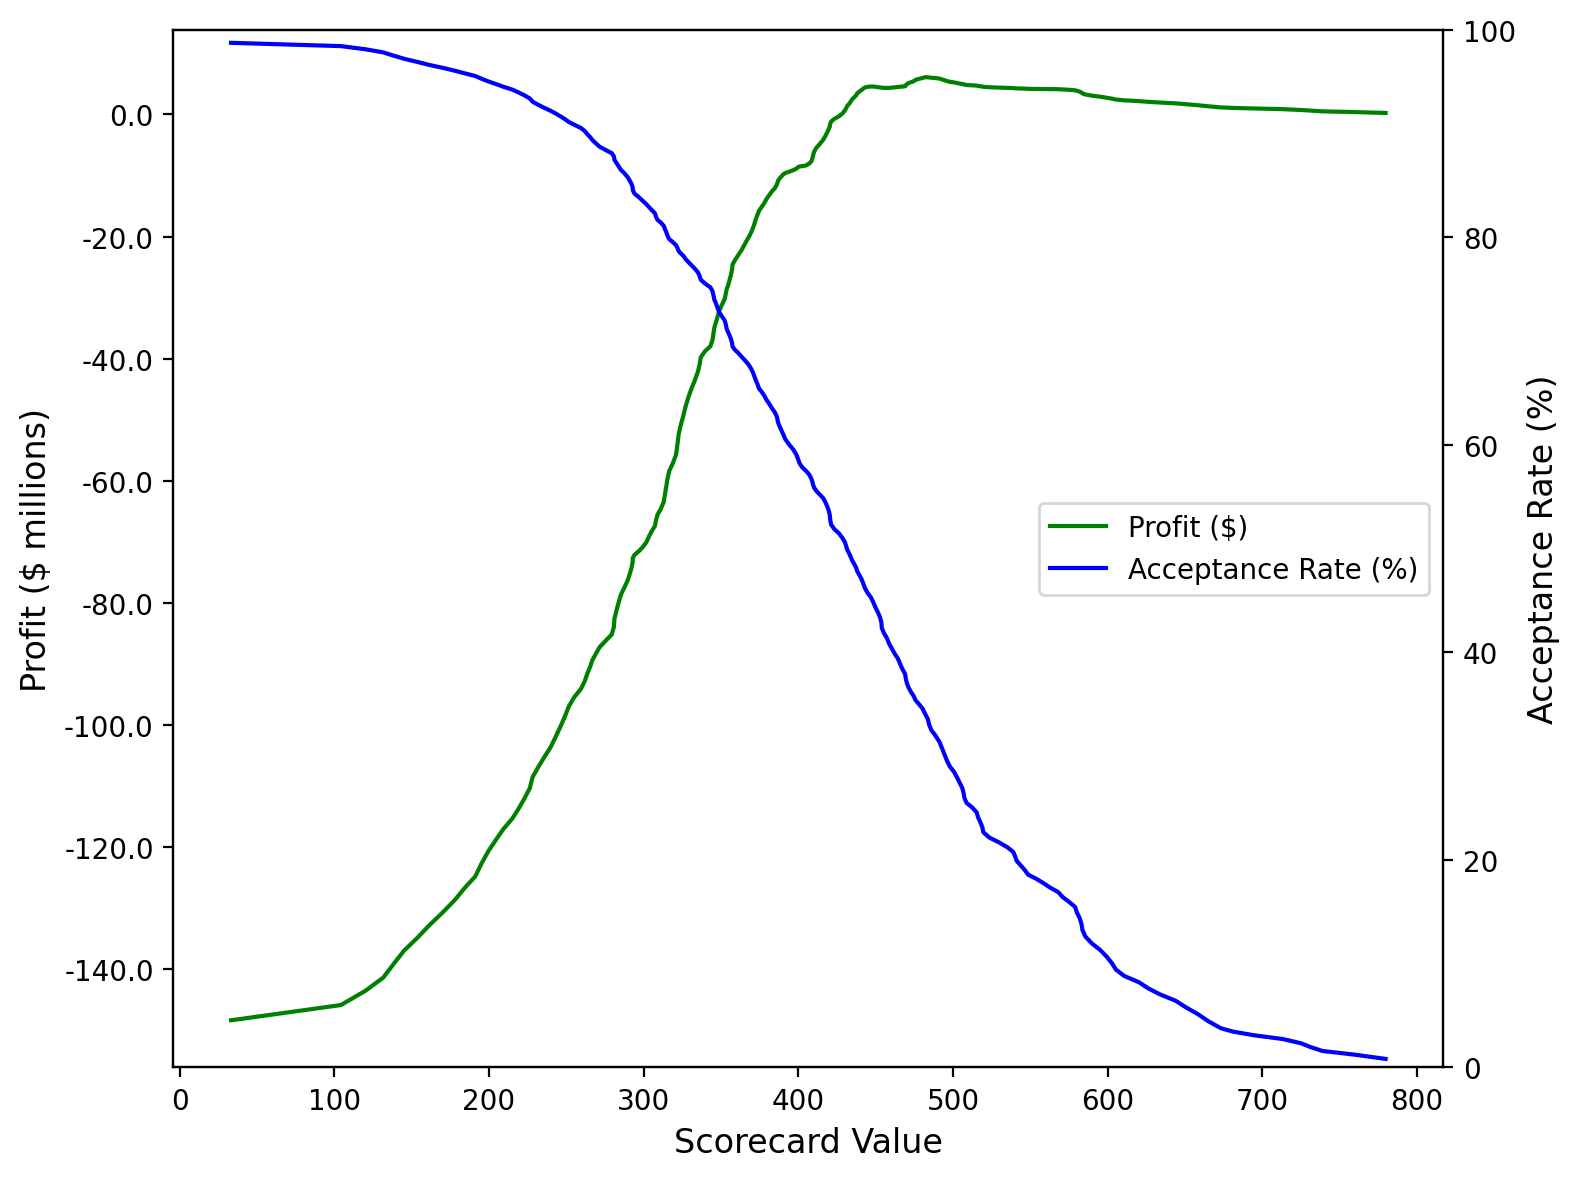

,_score_mid,wt,profit,cum_wt,cum_profit,accept_rate_pct
0,779.6765,150.814242,247628.4830,150.814242,247628.483000,0.822256
1,759.7245,149.814242,299628.4830,300.628483,397442.724500,1.230657
2,738.8810,120.851393,187702.7864,421.479876,509948.400467,1.586423
3,731.0365,150.814242,247628.4830,572.294118,628108.359200,1.969869
4,724.9395,120.851393,187702.7864,693.145511,736544.891720,2.331716


In [49]:
# Adjust these economics to match your business case:
profit_if_good = 2000.0   # profit on a good loan
loss_if_bad    = 52000.0  # loss on a bad loan (positive number)

grp = plot_profit_and_acceptance_by_score(
    test_final,
    score_col="score",
    bad_col="GB",
    weight_col="_freq_" if "_freq_" in test_final.columns else None,
    profit_if_good=profit_if_good,
    loss_if_bad=loss_if_bad,
    n_bins=250,
    smooth_window=9,
    title=""
)

grp.head()



In [50]:
# Sort and compute cumulative metrics
df = test_final.copy()
df = df.sort_values("score", ascending=False)
w = df["_freq_"]

df["cum_weight"] = w.cumsum()
total_weight = w.sum()

df["accept_rate"] = df["cum_weight"] / total_weight
df["cum_bad"] = (df["GB"] * w).cumsum()
df["bad_rate"] = df["cum_bad"] / df["cum_weight"]
df["cum_good"] = ((1 - df["GB"]) * w).cumsum()
df["profit"] = df["cum_good"] * 2000 - df["cum_bad"] * 52000

# Max profit cutoff
best = df.loc[df["profit"].idxmax()]

# 75% acceptance cutoff
target_accept = 0.75
idx_acc75 = (df["accept_rate"] - target_accept).abs().idxmin()
acc75 = df.loc[idx_acc75]

# 3.23% default rate cutoff
target_bad = 0.0323
idx_def323 = (df["bad_rate"] - target_bad).abs().idxmin()
def323 = df.loc[idx_def323]


In [51]:
# making a summar table that shows cutoff for each goal 

summary = pd.DataFrame([
    {
        "Strategy": "Max Profit",
        "Cutoff Score": best["score"],
        "Acceptance Rate %": 100 * best["accept_rate"],
        "Default Rate %": 100 * best["bad_rate"],
        "Cumulative Profit ($)": best["profit"],
    },
    {
        "Strategy": "75% Acceptance",
        "Cutoff Score": acc75["score"],
        "Acceptance Rate %": 100 * acc75["accept_rate"],
        "Default Rate %": 100 * acc75["bad_rate"],
        "Cumulative Profit ($)": acc75["profit"],
    },
    {
        "Strategy": "3.23% Default",
        "Cutoff Score": def323["score"],
        "Acceptance Rate %": 100 * def323["accept_rate"],
        "Default Rate %": 100 * def323["bad_rate"],
        "Cumulative Profit ($)": def323["profit"],
    },
])

summary


,Strategy,Cutoff Score,Acceptance Rate %,Default Rate %,Cumulative Profit ($)
0,Max Profit,488.384217,34.357232,1.761446,6.609284e+06
1,75% Acceptance,346.502975,75.054783,8.691675,-3.707931e+07
2,3.23% Default,437.601001,49.286888,3.224780,2.337907e+06
